# Imports

In [66]:
import pandas as pd
import numpy as np
np.random.seed(2121)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [67]:
rdf = pd.read_csv('../data/rdf.csv')
ydf = pd.read_csv('../data/ydf.csv')

In [68]:
rdf.set_index('Unnamed: 0', inplace=True)
rdf.index.name = None

ydf.set_index('Unnamed: 0', inplace=True)
ydf.index.name = None

In [69]:
rdf.drop(['name_common', 'player_id'], axis=1, inplace=True)
ydf.drop(['name_common', 'player_id'], axis=1, inplace=True)

# Train-Test Split

In [70]:
rdf_target = 'runs_total_pg'
ydf_target = 'opprpg'

In [71]:
rdf_y = rdf[rdf_target]
rdf_X = rdf[[col for col in rdf.columns if col != rdf_target]]

ydf_y = ydf[ydf_target]
ydf_X = ydf[[col for col in ydf.columns if col != ydf_target]]

In [72]:
rdf_X_train, rdf_X_test, rdf_y_train, rdf_y_test,\
ydf_X_train, ydf_X_test, ydf_y_train, ydf_y_test =\
    train_test_split(rdf_X, rdf_y,
                     ydf_X, ydf_y,
                     test_size=0.2,
                     shuffle=True,
                     random_state = 1212)

## Standard Scale

In [73]:
# initialize
ss = StandardScaler()

# fit on Train
rdf_X_train_ss = pd.DataFrame(ss.fit_transform(rdf_X_train),
                              columns = rdf_X_train.columns,
                              index = rdf_X_train.index)

# transform test
rdf_X_test_ss = pd.DataFrame(ss.transform(rdf_X_test),
                         columns = rdf_X_test.columns,
                         index = rdf_X_test.index)

# fit on Train
ydf_X_train_ss = pd.DataFrame(ss.fit_transform(ydf_X_train),
                              columns = ydf_X_train.columns,
                              index = ydf_X_train.index)

# transform test
ydf_X_test_ss = pd.DataFrame(ss.transform(ydf_X_test),
                         columns = ydf_X_test.columns,
                         index = ydf_X_test.index)

# RFE

In [94]:
rfecv = RFECV(
            estimator=BayesianRidge(),
            step = 1,
            cv = 5,
            scoring='r2',
            min_features_to_select = 20)

rfecv.fit(rdf_X_train_ss,rdf_y_train)

rdf_cols_to_keep = rdf_X_train_ss.T[rfecv.ranking_==1].T.columns
rdf_cols_to_pc = rdf_X_train_ss.T[rfecv.ranking_!=1].T.columns

print(f'# of Columns Kept: {len(rdf_cols_to_keep)}')
print(f'# of Columns Dropped: {len(rdf_cols_to_pc)}')

# of Columns Kept: 20
# of Columns Dropped: 42


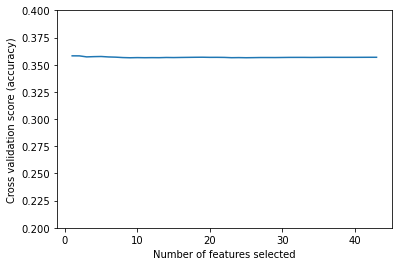

In [99]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score'])+1),
    rfecv.cv_results_['mean_test_score'],
)
plt.ylim(0.2,0.4)
plt.show()

# PCA

In [112]:
pca = PCA().fit(rdf_X_train_ss[rdf_cols_to_pc])

for i, l in enumerate(pca.explained_variance_[:5]):
    print('PC {}: {:.2f} --> {:.2f}%'.format(i, l,
                                             l * 100 / sum(pca.explained_variance_)))

PC 0: 7.54 --> 17.95%
PC 1: 4.37 --> 10.40%
PC 2: 3.60 --> 8.57%
PC 3: 3.24 --> 7.71%
PC 4: 3.04 --> 7.23%


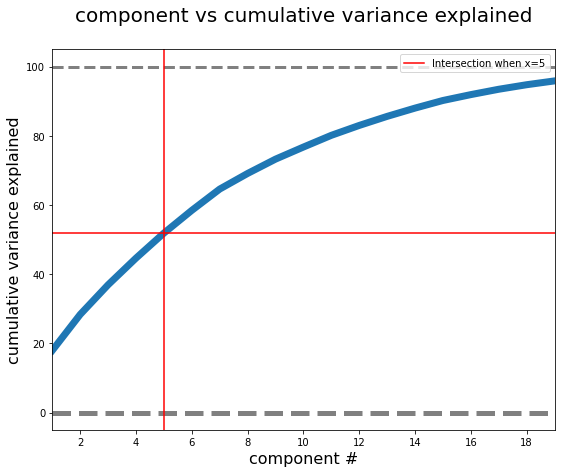

In [113]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(9,7))
component_number = range(1, len(rdf_cols_to_pc)+1)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,19])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component #', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20)
ax.axhline(y=np.cumsum(pca.explained_variance_ratio_)[4]*100, c='r', label='Intersection when x=5')
ax.axvline(x=5,  c='r')
ax.legend();

In [116]:
rdf_pca_train = pd.DataFrame(pca.transform(rdf_X_train_ss[rdf_cols_to_pc])[:,:5],
                     columns = ['pc_' + str(i) for i in range(5)],
                     index = rdf_X_train_ss.index)

rdf_pca_test = pd.DataFrame(pca.transform(rdf_X_test_ss[rdf_cols_to_pc])[:,:5],
                     columns = ['pc_' + str(i) for i in range(5)],
                     index = rdf_X_test_ss.index)

In [117]:
rdf_X_train_ss = pd.concat([rdf_X_train_ss[rdf_cols_to_keep], rdf_pca_train], axis=1)
rdf_X_test_ss = pd.concat([rdf_X_test_ss[rdf_cols_to_keep], rdf_pca_test], axis=1)

# Exports

In [119]:
rdf_X_train_ss.to_csv('../data/rdf_x_train_preprocessed.csv')
rdf_y_train.to_csv('../data/rdf_y_train_preprocessed.csv')

rdf_X_test_ss.to_csv('../data/rdf_x_test_preprocessed.csv')
rdf_y_test.to_csv('../data/rdf_y_test_preprocessed.csv')

ydf_X_train_ss.to_csv('../data/ydf_x_train_preprocessed.csv')
ydf_y_train.to_csv('../data/ydf_y_train_preprocessed.csv')

ydf_X_test_ss.to_csv('../data/ydf_x_test_preprocessed.csv')
ydf_y_test.to_csv('../data/ydf_y_test_preprocessed.csv')